#Neural Net with NumPy

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


Loading and visualizing the data

Dataset used: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Bicicletas.csv')
data.head()

,clima,temperatura,bicicletas_alugadas
0,2,0.363625,985
1,2,0.353739,801
2,1,0.189405,1349
3,1,0.212122,1562
4,1,0.229270,1600


In [3]:
data.shape

(731, 3)

relation between features

Text(0.5, 0, 'temperature')

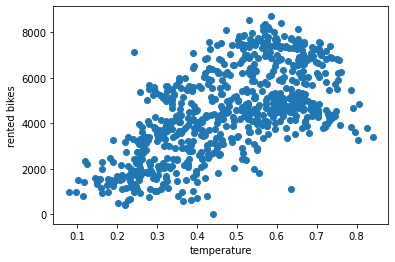

In [4]:
plt.scatter(data.temperatura, data.bicicletas_alugadas)
plt.ylabel('rented bikes')
plt.xlabel('temperature')

Text(0.5, 0, 'weather')

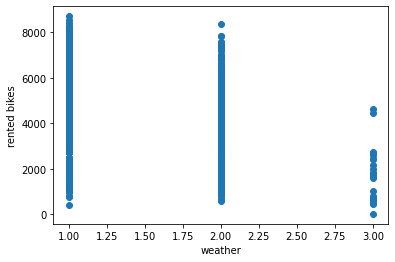

In [5]:
plt.scatter(data.clima, data.bicicletas_alugadas)
plt.ylabel('rented bikes')
plt.xlabel('weather')

Normalizing data

In [6]:
y = data.bicicletas_alugadas.values
x = data[['clima', 'temperatura']].values

In [7]:
print(x)

[[2.       0.363625]
 [2.       0.353739]
 [1.       0.189405]
 ...
 [2.       0.2424  ]
 [1.       0.2317  ]
 [2.       0.223487]]


In [8]:
#divide by the maximum value per row
#return values between 0 and 1
x = x/np.amax(x,axis=0)
print(x)

[[0.66666667 0.43242565]
 [0.66666667 0.42066914]
 [0.33333333 0.22524188]
 ...
 [0.66666667 0.28826395]
 [0.33333333 0.27553942]
 [0.66666667 0.26577246]]


In [9]:
ymax = np.amax(y)
y = y/ymax
y.shape

(731,)

Creating the model

In [10]:
def sigmoid(sum):
  return 1/(1+np.exp(-sum))

def relu(sum):
  return np.maximum(0, sum)

In [11]:
architecture = [
    {"input_dim": 2, "output_dim":64, "activation":'relu'},
    {"input_dim": 64, "output_dim": 1, "activation": "sigmoid"}, #OUTPUT LAYER
]


In [12]:
def initialize_layers(architecture, seed = 42):
  np.random.seed(seed)
  num_layers = len(architecture)
  parameters = {}

  for index, layer in enumerate(architecture):
    layer_index = index + 1

    layer_input_size = layer["input_dim"]
    layer_output_size = layer['output_dim']


    parameters['W' + str(layer_index)] = np.random.randn(layer_output_size, layer_input_size) *0.1
    parameters['b' + str(layer_index)] = np.random.randn(layer_output_size, 1)*0.1

  return parameters

In [13]:
def fowardprop_one_layer(last_activated, weights, biases, activation_func = 'relu'):
  
  output = np.dot(weights, last_activated) + biases

  if activation_func == 'relu':
    return relu(output), output
  elif activation_func == 'sigmoid':
    return sigmoid(output), output
  else:
    print("ACTIVATION FUNCTION ERROR")
  

In [14]:
def foward_propagation(X, parameters, architecture):
  history = {}
  current = X

  for index, layer in enumerate(architecture):
    index_layer = index+1

    last_activated = current
    
    activation = layer["activation"]
    
    weights = parameters["W" + str(index_layer)]
    
    bias = parameters['b' + str(index_layer)]
    
    current, output = fowardprop_one_layer(last_activated, weights, bias, activation)
    
    history["A" + str(index)] = last_activated
    
    history['Z' + str(index_layer)] = output

  return current, history

In [15]:
def loss_func(yhat, ytrue):
  m = yhat.shape[1]
  cost = -1 /m * (np.dot(ytrue,np.log(yhat).T) + np.dot(1-ytrue, np.log(1-yhat).T))
  return np.squeeze(cost)

In [16]:
def update(parameters, gradient, architecture, learning_rate):

  for layer_index, layer in enumerate(architecture,1):
    parameters['W' + str(layer_index)] -= learning_rate * gradient['dW' + str(layer_index)] 
    parameters['b' + str(layer_index)] -= learning_rate * gradient['db' + str(layer_index)]    

  return parameters

In [17]:
def sigmoid_backprop(dActivated, output):
  sig = sigmoid(output)
  return dActivated * sig * (1-sig)
def relu_backprop(dActivated, output):
  d = np.array(dActivated, copy = True)
  d[output <= 0] = 0
  return d

In [18]:
def backpropagation(yhat, Y, history, parameters, architecture):
  gradients ={}
  Y = Y.reshape(yhat.shape)

  prev_dActivated = - (np.divide(Y, yhat) - np.divide(1-Y, 1-yhat))

  for prev_layer_index, layer in reversed(list(enumerate(architecture))):

    current_layer_index = prev_layer_index + 1

    current_activation_function = layer['activation']

    current_dActivated = prev_dActivated

    prev_activated = history['A' + str(prev_layer_index)]
    current_output = history['Z' + str(current_layer_index)]

    current_weights = parameters['W' + str(current_layer_index)]
    current_biases = parameters['b' + str(current_layer_index)]

    prev_dActivated, current_dW, current_db = backprop_one_layer(current_dActivated, current_weights, current_biases, current_output, prev_activated, current_activation_function)
    gradients["dW" + str(current_layer_index)] = current_dW
    gradients["db" + str(current_layer_index)] = current_db
  
  return gradients

In [19]:
def backprop_one_layer(current_dActivated, current_weights, current_biases, current_output, prev_dActivated, activation = 'relu'):
  m = prev_dActivated.shape[1]
  if activation == 'relu':
    backprop_func = relu_backprop
  elif activation =='sigmoid':
    backprop_func = sigmoid_backprop
  else:
    raise Exception ("BACKPROPAGATION ACTIVATION FUNCTION ERROR")
  
  current_dOutput = backprop_func(current_dActivated, current_output)
  current_dW = np.dot(current_dOutput,prev_dActivated.T) / m
  current_db = np.sum(current_dOutput, axis = 1, keepdims = True) / m
  prev_dActivated = np.dot(current_weights.T, current_dOutput)

  return prev_dActivated, current_dW, current_db

In [20]:
def train(X, Y,x_test, y_test, architecture, epochs, learning_rate ):
  parameters = initialize_layers(architecture)
  loss_history =[]
  test_loss_history = []

  for i in range(epochs):
    yhat, history = foward_propagation(X = X, parameters=parameters, architecture = architecture)
    yhat_test, history2 = foward_propagation(X = x_test, parameters=parameters, architecture = architecture)
    
    loss = loss_func(yhat, Y)
    loss_history.append(loss)
    test_loss = loss_func(yhat_test, y_test)
    test_loss_history.append(test_loss)

    gradients = backpropagation(yhat, Y, history, parameters, architecture)
    parameters = update(parameters, gradients, architecture, learning_rate)

    if (i%50):
      print(f"Iteration: {i} ---- loss: {loss} ")

  return parameters, loss_history, test_loss_history

Testing the network

In [21]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [23]:
parameters, loss_history, test_loss_history = train(np.transpose(x_train), np.transpose(y_train.reshape((y_train.shape[0],1))), 
                                                    np.transpose(x_test),np.transpose(y_test.reshape((y_test.shape[0],1))),
                                                   architecture, 10000, 0.01)

A saída de streaming foi truncada nas últimas 5000 linhas.
Iteration: 4898 ---- loss: 0.6625242464478225 
Iteration: 4899 ---- loss: 0.6625177121364968 
Iteration: 4901 ---- loss: 0.6625046482765645 
Iteration: 4902 ---- loss: 0.6624981184031666 
Iteration: 4903 ---- loss: 0.6624915895899597 
Iteration: 4904 ---- loss: 0.6624850618393814 
Iteration: 4905 ---- loss: 0.6624785351218418 
Iteration: 4906 ---- loss: 0.6624720094997498 
Iteration: 4907 ---- loss: 0.6624654849341102 
Iteration: 4908 ---- loss: 0.6624589614185561 
Iteration: 4909 ---- loss: 0.6624524390643914 
Iteration: 4910 ---- loss: 0.6624459179522508 
Iteration: 4911 ---- loss: 0.6624393979065349 
Iteration: 4912 ---- loss: 0.6624328789280536 
Iteration: 4913 ---- loss: 0.6624263614585714 
Iteration: 4914 ---- loss: 0.6624198457888277 
Iteration: 4915 ---- loss: 0.6624133311897836 
Iteration: 4916 ---- loss: 0.6624068176622445 
Iteration: 4917 ---- loss: 0.6624003052070158 
Iteration: 4918 ---- loss: 0.6623937938249014 
I

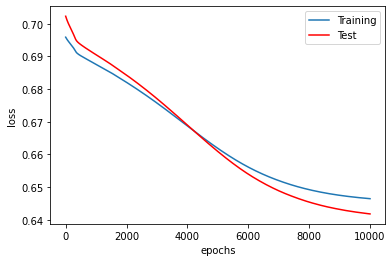

In [24]:
plt.plot(loss_history)
plt.plot(test_loss_history, 'r')
plt.legend(['Training','Test'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

predicting

In [25]:
Y_pred, _ = foward_propagation(np.transpose(x_test), parameters, architecture)

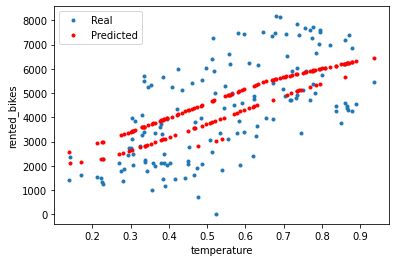

In [26]:
plt.plot(np.transpose(x_test)[1],ymax*y_test,'.')
plt.plot(np.transpose(x_test)[1],ymax*Y_pred.reshape([-1,1]),'.r')
plt.legend(['Real','Predicted'])
plt.ylabel('rented_bikes')
plt.xlabel('temperature')
plt.show()

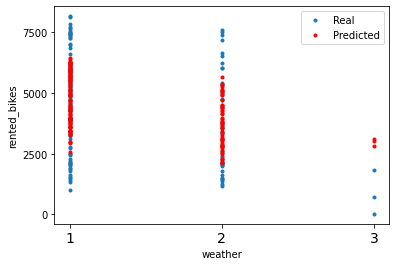

In [27]:
plt.plot(3*np.transpose(x_test)[0],ymax*y_test,'.')
plt.plot(3*np.transpose(x_test)[0],ymax*Y_pred.reshape([-1,1]),'.r')
plt.legend(['Real','Predicted'])
plt.ylabel('rented_bikes')
plt.xlabel('weather')
plt.rcParams.update({'font.size': 22})
indice=[1,2,3]
plt.xticks(indice, fontsize=14)
plt.show()